In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import jax.numpy as jnp
import pymdp.jax
from fast_structure_learning import *

In [4]:
path_to_file = "frames.npz"
num_frames = 256
frames = read_frames_from_npz(path_to_file, num_frames=num_frames)
frames = frames[128:, ...]

In [5]:
frames.shape

(128, 64, 64, 3)

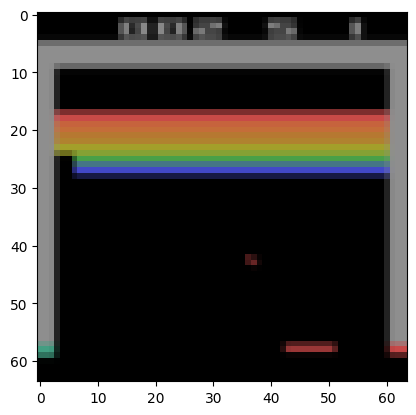

In [6]:
plt.imshow(frames[0])

In [7]:
(observations, locations_matrix, group_indices, sv_discrete_axis, V_per_patch), patch_indices = map_rgb_2_discrete(frames, tile_diameter=16, n_bins=9)
observations = jnp.asarray(observations)

In [8]:
observations.shape

(131, 64, 9)

In [9]:
agents, RG, LB = spm_mb_structure_learning(observations, locations_matrix, max_levels=8)

Maximum probability state about factor 0 at time 0: 8
Maximum probability state about factor 0 at time 1: 8
Maximum probability state about factor 0 at time 2: 8
Maximum probability state about factor 0 at time 3: 8
Maximum probability state about factor 0 at time 4: 8
Maximum probability state about factor 0 at time 5: 8
Maximum probability state about factor 0 at time 6: 3
Maximum probability state about factor 0 at time 7: 1
Maximum probability state about factor 0 at time 8: 1
Maximum probability state about factor 0 at time 9: 1
Maximum probability state about factor 0 at time 10: 1
Maximum probability state about factor 0 at time 11: 1
Maximum probability state about factor 0 at time 12: 1
Maximum probability state about factor 0 at time 13: 1
Maximum probability state about factor 0 at time 14: 1
Maximum probability state about factor 0 at time 15: 1
Maximum probability state about factor 0 at time 16: 1
Maximum probability state about factor 0 at time 17: 1
Maximum probability 

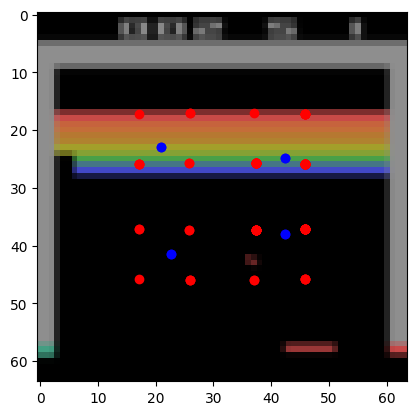

In [10]:
import matplotlib.pyplot as plt

plt.imshow(frames[0])
colors = ['r', 'b']
for (i,locations_matrix) in enumerate(LB):
    plt.scatter(locations_matrix[:,0], locations_matrix[:,1], c=colors[i])
plt.show()

In [11]:
one_hot = jnp.zeros([1, 32])
one_hot = one_hot.at[0, 16].set(1.0)
D = one_hot

In [12]:
from pymdp.jax.control import compute_expected_obs
from jax import vmap
from functools import partial

expected_obs = partial(compute_expected_obs, A_dependencies=agents[-1].A_dependencies)

qo = vmap(expected_obs)([D,], agents[-1].A)

In [13]:
import jax.tree_util as jtu

expected_obs2 = partial(compute_expected_obs, A_dependencies=agents[-2].A_dependencies)

# split this in initial state "D" and path "E"
D2 = qo[::2]
for i in range(len(agents[-2].B)):
    D2[i] = D2[i][:, :agents[-2].B[i].shape[1]]
# TODO also transition using this policy matrix?
E2 = jtu.tree_map(lambda x: jnp.expand_dims(jnp.argmax(x), [0]), qo[1::2])

qs_next, _ = agents[-2].infer_empirical_prior(E2, jtu.tree_map(lambda x : jnp.expand_dims(x, 0), D2))

# stack D2 and qs_next and generate qo at once
#qo2 = vmap(expected_obs2)(D2, agents[-2].A)
#qo2_nxt = vmap(expected_obs2)(qs_next, agents[-2].A)

stacked = []
for x,y in zip(D2, qs_next):
    stacked.append(jnp.concatenate([x, y], axis=0))

A_stacked = jtu.tree_map(lambda x: jnp.broadcast_to(x, (2, x.shape[1], x.shape[2])), agents[-2].A)
qo_stacked = vmap(expected_obs2)(stacked, A_stacked)


In [14]:
obs = jnp.array(qo_stacked)

# vmap over the batch dimension
#img = map_discrete_2_rgb(obs[:, 0, :], locations_matrix, group_indices, sv_discrete_axis, V_per_patch, patch_indices, frames.shape[-3:])
#img2 = map_discrete_2_rgb(obs[:, 1, :], locations_matrix, group_indices, sv_discrete_axis, V_per_patch, patch_indices, frames.shape[-3:])

map_discrete_2_rgb_fn = partial(map_discrete_2_rgb, locations_matrix=locations_matrix, group_indices=group_indices, sv_discrete_axis=sv_discrete_axis, V_per_patch=V_per_patch, patch_indices=patch_indices, image_shape=frames.shape[-3:])
imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(obs)
imgs = imgs.reshape((4, imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

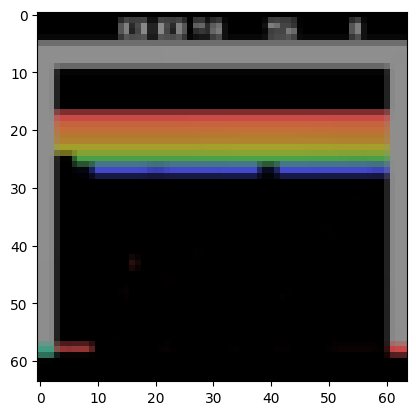

In [15]:
import numpy as onp

def to_img(img):
    im = jnp.transpose(img, (1, 2, 0))
    im /= 255
    im = jnp.clip(im, 0, 1)
    im = (255*im).astype(onp.uint8)
    return im

plt.imshow(to_img(imgs[0]))


In [16]:
!pip install -q mediapy

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


predictions

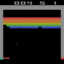

In [17]:
import mediapy

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"predictions": ims}, width=320, height=320, fps=1, codec='gif')


In [18]:
agents[-1].B[0].shape

(1, 32, 32, 1)

generations

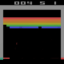

In [64]:
# generate n step predictions
one_hot = jnp.zeros([1, 32])
one_hot = one_hot.at[0, 16].set(1.0)
D = [one_hot]
E = jnp.array([[0]])
observations, beliefs = predict(agents, D, E, num_steps=12)

# convert to images
obs = jnp.array(observations[0])
map_discrete_2_rgb_fn = partial(map_discrete_2_rgb, locations_matrix=locations_matrix, group_indices=group_indices, sv_discrete_axis=sv_discrete_axis, V_per_patch=V_per_patch, patch_indices=patch_indices, image_shape=frames.shape[-3:])
imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(obs)
imgs = imgs.reshape((imgs.shape[0]*imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"generations": ims}, width=320, height=320, fps=4, codec='gif')